# Ejercicio

Trades at close

Comisión: $0.125\%$

$SL=TP=5\%$

Cash: $\$1 M$

N shares: $50$

No taxes

No leverages

Margin acc: $50\%$

Borrow rate: $0.25\%$

Time frame: $5m$

In [1]:
import ta
import optuna
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
sns.set_theme()

In [2]:
data = pd.read_csv('aapl_5m_train.csv').dropna()
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,0,1609770600,0,2021-01-04 14:30:00,133.570007,133.611602,132.389999,132.809997,6624663.0
1,1,1609770900,0,2021-01-04 14:35:00,132.750000,132.750000,131.809997,131.889999,2541553.0
2,2,1609771200,0,2021-01-04 14:40:00,131.500000,132.339996,131.500000,132.059997,2492415.0
3,3,1609771500,0,2021-01-04 14:45:00,132.000000,132.250000,131.899993,132.250000,1859131.0
4,4,1609771800,0,2021-01-04 14:50:00,132.000000,132.018096,131.520004,131.589996,1780105.0


## Código no optimizado

In [3]:
rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=20)
data['rsi'] = rsi_indicator.rsi()

In [4]:
historic = data.dropna()
historic['buy_signal'] = historic.rsi < 20
historic['sell_signal'] = historic.rsi > 80

In [5]:
historic.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,rsi,buy_signal,sell_signal
19,19,1609776300,0,2021-01-04 16:05:00,130.309997,130.549896,129.660003,129.866699,3030766.0,26.683236,False,False
20,20,1609776600,0,2021-01-04 16:10:00,129.860000,130.239898,129.399993,130.089996,2231137.0,30.749593,False,False
21,21,1609776900,0,2021-01-04 16:15:00,130.080093,130.354995,129.904602,130.324996,1328068.0,34.758166,False,False
22,22,1609777200,0,2021-01-04 16:20:00,130.324005,130.419998,129.930099,129.996398,1233893.0,32.029264,False,False
23,23,1609777500,0,2021-01-04 16:25:00,129.994995,130.206695,129.880004,129.895004,1144809.0,31.232801,False,False


In [6]:
from dataclasses import dataclass

@dataclass
class Operation:
    time: str
    price: float
    stop_loss: float
    take_profit: float
    n_shares: int
    type: str

In [7]:
def get_portfolio_value(cash: float, long_ops: list[Operation], short_ops: list[Operation], current_price:float, n_shares: int) -> float:
    val = cash

    # Add long positions value
    val += len(long_ops) * current_price * n_shares

    # TODO: Add short positions value
    return val

In [8]:
COM = 0.125 / 100
SL = 0.1
TP = 0.1
BORROW_RATE = 0.25 / 100

cash = 1_000_000
n_shares = 200

active_long_positions: list[Operation] = []

portfolio_value = [cash]

for i, row in historic.iterrows():
    # This only works for long positions
    
    # Close positions
    for position in active_long_positions.copy():
        if row.Close > position.take_profit or row.Close < position.stop_loss:
            cash += row.Close * position.n_shares * (1 - COM)
            active_long_positions.remove(position)
    # --- BUY ---
    # Check signal
    if not row.buy_signal:
        portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))
        continue
    # Do we have enough cash?
    if cash < row.Close * n_shares * (1 + COM):
        portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))
        continue
    # Discount the cost
    cash -= row.Close * n_shares * (1 + COM)
    # Save the operation as active position
    active_long_positions.append(
        Operation(
        time=row.Datetime,
        price=row.Close,
        take_profit=row.Close * (1 + TP),
        stop_loss=row.Close * (1 - SL),
        n_shares=n_shares,
        type="LONG"
        )
    )

    portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))

cash += row.Close * len(active_long_positions) * n_shares * (1 - COM)
active_long_positions = []

In [9]:
cash, len(active_long_positions)

(1175409.6117202505, 0)

## Código optimizado

In [10]:
from dataclasses import dataclass

@dataclass
class Operation:
    time: str
    price: float
    stop_loss: float
    take_profit: float
    n_shares: int
    type: str

In [11]:
def get_portfolio_value(cash: float, long_ops: list[Operation], short_ops: list[Operation], current_price:float, n_shares: int) -> float:
    val = cash

    # Add long positions value
    val += len(long_ops) * current_price * n_shares

    # TODO: Add short positions value
    return val

In [12]:
def backtest(data, trial) -> float:
    data = data.copy()

    rsi_window = trial.suggest_int('rsi_window', 5, 50)
    rsi_lower = trial.suggest_int('rsi_lower', 5, 35)
    rsi_upper = trial.suggest_int('rsi_upper', 65, 95)
    stop_loss = trial.suggest_float('stop_loss', 0.01, 0.15)
    take_profit = trial.suggest_float('take_profit', 0.01, 0.15)
    n_shares = trial.suggest_int('n_shares', 50, 500)

    rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=rsi_window)
    data['rsi'] = rsi_indicator.rsi()

    historic = data.dropna()
    historic['buy_signal'] = historic.rsi < rsi_lower
    historic['sell_signal'] = historic.rsi > rsi_upper

    COM = 0.125 / 100
    SL = 0.1
    TP = 0.1
    BORROW_RATE = 0.25 / 100

    cash = 1_000_000

    active_long_positions: list[Operation] = []

    portfolio_value = [cash]

    for i, row in historic.iterrows():
        # This only works for long positions
        
        # Close positions
        for position in active_long_positions.copy():
            if row.Close > position.take_profit or row.Close < position.stop_loss:
                cash += row.Close * position.n_shares * (1 - COM)
                active_long_positions.remove(position)
        # --- BUY ---
        # Check signal
        if not row.buy_signal:
            portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))
            continue
        # Do we have enough cash?
        if cash < row.Close * n_shares * (1 + COM):
            portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))
            continue
        # Discount the cost
        cash -= row.Close * n_shares * (1 + COM)
        # Save the operation as active position
        active_long_positions.append(
            Operation(
            time=row.Datetime,
            price=row.Close,
            take_profit=row.Close * (1 + TP),
            stop_loss=row.Close * (1 - SL),
            n_shares=n_shares,
            type="LONG"
            )
        )

        portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))

    cash += row.Close * len(active_long_positions) * n_shares * (1 - COM)
    active_long_positions = []

    return (cash / 1_000_000) - 1

In [13]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: backtest(data, trial), n_trials=10, n_jobs=-1)

[I 2025-09-12 09:26:29,727] A new study created in memory with name: no-name-6a6b6728-e9ad-4997-beaa-ad8b84936827
[I 2025-09-12 09:26:34,267] Trial 0 finished with value: 0.0 and parameters: {'rsi_window': 47, 'rsi_lower': 16, 'rsi_upper': 90, 'stop_loss': 0.14967875238421385, 'take_profit': 0.12419913264916642, 'n_shares': 420}. Best is trial 0 with value: 0.0.
[I 2025-09-12 09:26:34,548] Trial 6 finished with value: 0.028786927879644875 and parameters: {'rsi_window': 20, 'rsi_lower': 11, 'rsi_upper': 91, 'stop_loss': 0.06647958523781908, 'take_profit': 0.010169150911082994, 'n_shares': 377}. Best is trial 6 with value: 0.028786927879644875.
[I 2025-09-12 09:26:35,151] Trial 1 finished with value: 0.025435740355142844 and parameters: {'rsi_window': 41, 'rsi_lower': 21, 'rsi_upper': 71, 'stop_loss': 0.039392512796291176, 'take_profit': 0.12480597707058957, 'n_shares': 118}. Best is trial 6 with value: 0.028786927879644875.
[I 2025-09-12 09:26:39,603] Trial 4 finished with value: 0.2213

In [14]:
study.best_params

{'rsi_window': 22,
 'rsi_lower': 22,
 'rsi_upper': 81,
 'stop_loss': 0.05961753787718935,
 'take_profit': 0.07516992783777511,
 'n_shares': 230}

In [15]:
study.best_value

0.2330377841916489

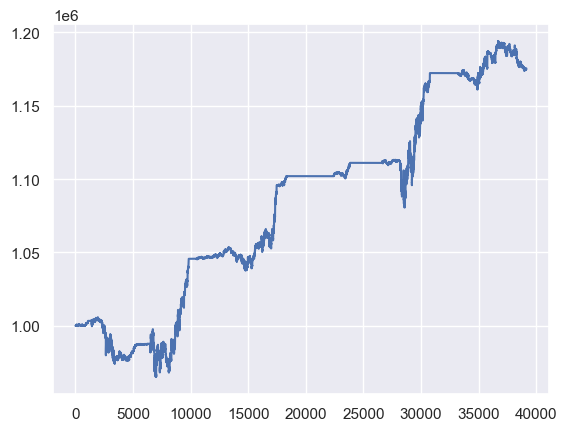

In [16]:
plt.plot(portfolio_value)